**ЛЕГЕНДА**

Вы работаете аналитиком в онлайн-школе MasterMind.

**ЦЕЛЬ**

Подготовить основу рекомендательной системы.

**ЗАДАЧИ**

Продакт ожидает получить от вас рекомендательную систему, благодаря которой можно будет предлагать клиентам интересные им курсы и тем самым повышать средний чек.

Вы решаете, что изначальным воплощением этой системы может стать таблица, в которой курсам будет соответствовать по две рекомендации.

Кроме того, вы планируете вместе с отчётом (таблицей рекомендаций) скинуть продакту ещё и все написанные в процессе скрипты, чтобы было меньше вопросов по решению. Ну, и раз в код будут смотреть не только ваши глаза, вы считаете необходимым снабдить его комментариями, которые бы разъясняли, что где и почему вы делаете.

In [2]:
# импортируем необходимые для работы кода библиотеки

import pandas as pd
import psycopg2
import psycopg2.extras
import numpy as np
import itertools
from collections import Counter

# подгружаем данные из базы данных

def get_data():
    query = '''
    WITH users_with_one_more_course  AS
(SELECT FC.user_id users,
count(FCI.resource_id) count_course
from final.carts FC
join final.cart_items FCI on FCI.cart_id=FC.id
where FC.state='successful' and FCI.resource_type='Course'
group by FC.user_id
having count(distinct FCI.resource_id)>1),
base_table AS
(SELECT *
from final.carts FC
join final.cart_items FCI on FCI.cart_id=FC.id
where FCI.resource_type='Course' and FC.state='successful'
)
SELECT
distinct UWOMC.users,
BS.resource_id
from users_with_one_more_course UWOMC
left join base_table BS on UWOMC.users=BS.user_id
    '''
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data


df = pd.DataFrame(get_data()) #преобразование полученных данных в таблицу
df.info()  #проверяем данные


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34074 entries, 0 to 34073
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   users        34074 non-null  int64
 1   resource_id  34074 non-null  int64
dtypes: int64(2)
memory usage: 532.5 KB


56.3.6 Сколько различных пар курсов встречаются вместе в покупках клиентов?

1. Сгруппировать уникальные курсы по пользователям.
2. Разбить курсы внутри пользователей по парам.
3. Посчитать количество уникальных пар.


In [3]:
df1 = df.groupby('users')['resource_id'].apply(lambda x:list(np.unique(x))).reset_index()
courses=list()
display(df1)

,users,resource_id
0,51,"[516, 1099]"
1,6117,"[356, 357, 1125]"
2,10275,"[553, 1147]"
3,10457,"[361, 1138]"
4,17166,"[356, 357]"
...,...,...
12651,2179430,"[566, 750]"
12652,2186581,"[794, 864, 1129]"
12653,2187601,"[356, 553, 571, 765, 912]"
12654,2188926,"[515, 743]"


In [4]:

course_list = []  #создаем пустой список для внесения в него пар курсов
for course in df1['resource_id']:  #проходимся по списку курсов пользователя
    for value in itertools.combinations(course, 2): #генерация сочетаний элементов списка без повторений по парам
        course_list.append(value)  #добавляем пару в список
    unique_course_list = list(set(course_list))  #получаем уникальные пары в списке
count_of_unique_courses = Counter(unique_course_list)  #считаем значения уникальных пар курсов
count_of_courses = Counter(course_list)
print(sum(count_of_unique_courses.values())) #считаем сумму всех значений в объекте Counter


3989


Ответ: 3 989 различных пар курсов встречаются у пользователей

56.3.7 Найдите самую популярную пару курсов. Какие у них ID?

In [5]:
popular_pair = Counter(count_of_courses).most_common()
print(popular_pair)

[((551, 566), 797), ((515, 551), 417), ((489, 551), 311), ((523, 551), 304), ((566, 794), 290), ((489, 515), 286), ((490, 566), 253), ((490, 551), 247), ((570, 752), 247), ((569, 572), 216), ((515, 523), 213), ((553, 745), 212), ((489, 523), 206), ((569, 840), 204), ((514, 551), 200), ((516, 745), 199), ((515, 566), 195), ((489, 566), 188), ((504, 572), 184), ((572, 840), 178), ((551, 552), 177), ((507, 570), 172), ((490, 809), 163), ((489, 490), 152), ((507, 752), 150), ((523, 552), 144), ((490, 515), 143), ((551, 570), 142), ((504, 569), 139), ((514, 515), 139), ((551, 745), 138), ((514, 566), 138), ((502, 551), 135), ((504, 840), 135), ((571, 1125), 122), ((502, 566), 120), ((523, 566), 120), ((570, 809), 119), ((752, 809), 115), ((490, 523), 114), ((357, 571), 112), ((523, 564), 110), ((551, 749), 109), ((516, 553), 107), ((551, 777), 107), ((551, 679), 104), ((356, 571), 103), ((551, 564), 103), ((515, 749), 103), ((568, 745), 102), ((356, 357), 100), ((363, 511), 99), ((551, 571)

Ответ: самая популярная пара 551, 566.

**Задание**

Необходимо оформить таблицу, которая станет основой рекомендательной системы.

Прежде всего нужно установить минимальную границу — какое количество раз считать слишком малым.
Вместо малопопулярного курса вывести какой-то другой курс, который, на ваш аргументированный взгляд, подходит лучше.

Итоговая таблица должна состоять из трёх столбцов:

*   Курс, к которому идёт рекомендация.
*   Курс для рекомендации № 1 (самый популярный).
*   Курс для рекомендации № 2 (второй по популярности).

In [6]:
df_pairs = pd.DataFrame(popular_pair,columns=['pair', 'frequency'])  #создадим дата фрейм курсов с частотой покупки
display(df_pairs)

,pair,frequency
0,"(551, 566)",797
1,"(515, 551)",417
2,"(489, 551)",311
3,"(523, 551)",304
4,"(566, 794)",290
...,...,...
3984,"(741, 791)",1
3985,"(361, 1128)",1
3986,"(743, 1156)",1
3987,"(864, 1129)",1


1. Построим сводную таблицу по частоте пар курсов, чтобы увидеть, сколько пар встречаются один раз, два раза и т .д. 
2. А далее посмотрим на распределение сумм частот.

In [7]:
pivot = df_pairs.groupby(by = 'frequency')['pair'].agg(['sum','count'])  #группируем пары курсов по частоте, определяем количество пар с такой частотой
display(pivot)

,sum,count
frequency,,
1,"(1125, 1140, 744, 1138, 513, 1125, 502, 865, 1...",1185
2,"(744, 862, 571, 1099, 765, 862, 765, 864, 862,...",578
3,"(862, 1138, 564, 865, 367, 513, 672, 679, 672,...",366
4,"(568, 672, 552, 1138, 800, 1125, 356, 672, 679...",259
5,"(509, 672, 1146, 1187, 1147, 1187, 366, 1125, ...",202
...,...,...
290,"(566, 794)",1
304,"(523, 551)",1
311,"(489, 551)",1


(array([120.,   4.,   2.,   1.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.0000e+00, 6.0200e+01, 1.1940e+02, 1.7860e+02, 2.3780e+02,
        2.9700e+02, 3.5620e+02, 4.1540e+02, 4.7460e+02, 5.3380e+02,
        5.9300e+02, 6.5220e+02, 7.1140e+02, 7.7060e+02, 8.2980e+02,
        8.8900e+02, 9.4820e+02, 1.0074e+03, 1.0666e+03, 1.1258e+03,
        1.1850e+03]),
 <BarContainer object of 20 artists>)

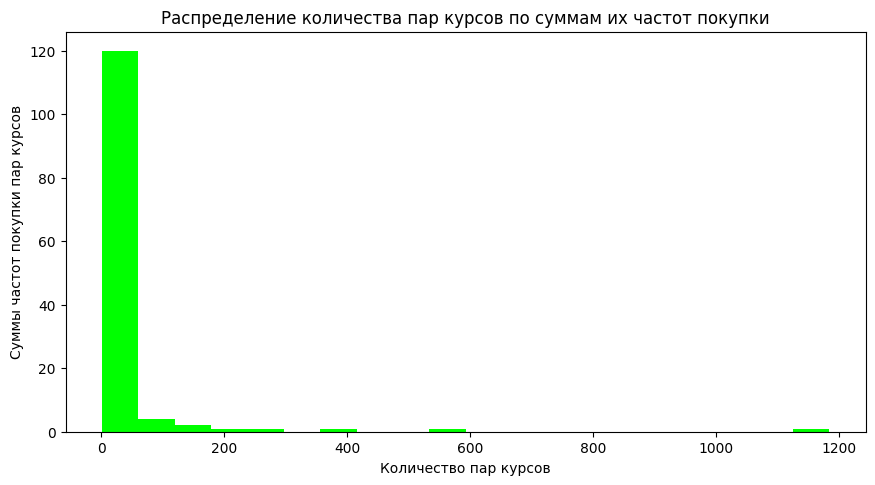

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.set_title('Распределение количества пар курсов по суммам их частот покупки')
axes.set_xlabel('Количество пар курсов')
axes.set_ylabel('Суммы частот покупки пар курсов')
axes.hist(x=pivot['count'], color='lime', bins = 20)

Сводная таблица и график показывают, что:

1. Из 3989 различных пар курсов, которые покупают пользователи, на каждую из 1185 пар курсов (29.7 % от всех уникальных пар курсов) приходится одна покупка, на 578 пар (14.5 % от всех уникальных пар курсов) - 2 покупки, 366 (9.2 %) - 3 покупки и т.д.
2. При этом есть некоторый набор пар курсов, на которые приходятся самые частотные покупки, например, пара (551, 566) была куплена 797 раз.
3. Посмотрим, как распределены частоты покупок курсов.

In [9]:
pivot.describe()

,count
count,131.000000
mean,30.450382
std,122.442088
min,1.000000
25%,1.000000
50%,2.000000
75%,8.000000
max,1185.000000


Видим, что среди 131 варианта распределения пар курсов по частотам, 75% приходятся на случаи, в которых не более 8 разных пар. Среднее значение - 30 пар, находится в 4-ом квартиле.

Будем рекомендовать курсы из 4-го квартиля (count>8).

In [10]:
df_base_recommend = pivot[pivot['count']>8] #база курсов, из которой будем рекомендовать
display(df_base_recommend)

,sum,count
frequency,,
1,"(1125, 1140, 744, 1138, 513, 1125, 502, 865, 1...",1185
2,"(744, 862, 571, 1099, 765, 862, 765, 864, 862,...",578
3,"(862, 1138, 564, 865, 367, 513, 672, 679, 672,...",366
4,"(568, 672, 552, 1138, 800, 1125, 356, 672, 679...",259
5,"(509, 672, 1146, 1187, 1147, 1187, 366, 1125, ...",202
6,"(552, 862, 865, 1103, 1144, 1186, 366, 513, 51...",148
7,"(356, 552, 357, 1144, 745, 1101, 1139, 1147, 7...",148
8,"(551, 862, 552, 744, 356, 679, 509, 514, 515, ...",95
9,"(519, 912, 1139, 1146, 1139, 1187, 517, 571, 5...",80


Создадим функцию рекомендаций:

На вход подается номер курса, возвращается 2 курса, с которым поданный на вход курс чаще всего продавался.

In [11]:
popular_course = df.groupby(by = 'resource_id')['users'].count().sort_values(ascending=False) #проверим, какие курсы были самыми популярными
display (popular_course)

resource_id
551     2935
566     2342
515     1311
489     1125
490     1084
        ... 
902        3
833        3
1199       2
1200       2
1201       2
Name: users, Length: 126, dtype: int64

Будем рекомендовать самый популярный курс 551 к тем курсам, у которых частота покупки меньше 9

In [12]:
def recommend(course):  #подаем на вход номер курса
    course_list = []  #создаем пустой список
    for i in count_of_courses.keys():  #проходим по ключам словаря
        if i[0] == course and count_of_courses[i] > 9:  #если первое значение ключа в паре соответствует номеру курса и частота покупки курса больше 9
            course_list.append((i,count_of_courses[i]))  #добавляем в созданный список ключ и его значение
        if course ==i[1] and count_of_courses[i] > 9:  #если второе значение ключа в паре соответствует значению курса и частота покупки курса больше 9
            course_list.append((i,count_of_courses[i]))  #добавляем в созданный список ключ и его значение
        else:
            return [551], #если попался курс, для которого нет пары, предлагаем посмотреть на самые популярные курсы
        return course_list
    sorted_course_list = sorted(course_list, key=lambda x:x[1], reverse=True)  #сортировка списка по убыванию
    return sorted_course_list[:2]  #возвращаем две самые популярные пары

Зададим цикл по списку уникальным курсам и запишем результаты в датафрейм.

In [13]:
unique_course_id = list(df['resource_id'].unique())  #формируем уникальный список курсов

In [26]:
df_with_recommendation = pd.DataFrame(columns = ['course', '1st_recommendation', '2nd_recommendation'])  #создадим дата фрейм рекомендованных курсов
for course in unique_course_id:  #начинаем перебирать уникальные курсы, которые покупали хотя бы один раз, один за одним
    df_with_recommendation['course'] = df['resource_id'].unique()  #записываем значение курса, к которому будем рекомендовать
    
    #df_with_recommendation['1st_recommendation'] = df_with_recommendation['course'].apply(lambda x:recommend(x)[1])  #применяем функцию и записываем рекомендации

    df_with_recommendation['2nd_recommendation'] = df_with_recommendation['course'].apply(lambda x:recommend(x)[0])  #применяем функцию и записываем рекомендации
display(df_with_recommendation.head(10))


,course,1st_recommendation,2nd_recommendation
0,356,NaN,[551]
1,515,NaN,[551]
2,566,NaN,[551]
3,679,NaN,[551]
4,504,NaN,[551]
5,551,NaN,[551]
6,570,NaN,[551]
7,514,NaN,[551]
8,571,NaN,[551]
9,1129,NaN,[551]
